In [27]:
import os
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import codecs
from os import path

import ktrain
from ktrain import text
import pickle
import pandas as pd
import string

# Preprocessing

Preprocessing data in a dataframe file with host,text,text_label,num_label

In [19]:
Train_data = pd.DataFrame()
# Read training data
with open("train.csv", 'r') as f:
    train_data = f.read().splitlines()

train_hosts = list()
y_train = list()
for row in train_data:
    host, label = row.split(",")
    train_hosts.append(host)
    y_train.append(label.lower())



# Load the textual content of a set of webpages for each host into the dictionary "text". 
# The encoding parameter is required since the majority of our text is french.
texts = dict()
filenames = os.listdir('text/text')
for filename in filenames:
    with codecs.open(path.join('text/text/', filename),'r', encoding="utf8", errors = 'ignore') as f: 
        texts[filename] = f.read().replace("\n", "").lower()
        #print(f.read().replace("\n", "").lower())
    

train_data = list()
for host in train_hosts:
    if host in texts:
        train_data.append(texts[host])
    else:
        train_data.append('')

Model_Name = 'distilbert-base-multilingual-cased'
classes = ['business/finance','education/research','entertainment','health/medical','news/press','politics/government/law','sports','tech/science']

classes_to_label = {'business/finance' : 0,'education/research':1,'entertainment':2,'health/medical':3,'news/press':4,
'politics/government/law':5,'sports':6,'tech/science' : 7}
y_train_num = [classes_to_label[i] for i in y_train]

In [20]:
Train_data['host'] = train_hosts
Train_data['text'] = train_data
Train_data['label_text'] = y_train
Train_data['label_num'] = y_train_num


In [21]:
train_data[0]

'   #polepharma » flux polepharma » flux des commentaires alternate   alternate   polepharma   polepharma \ufeff recherche_________ submit   (button) toggle navigation   polepharma     * polepharma          + qui sommes-nous ?          + organigramme          + les chiffres clés          + un réseau     * territoires          + région centre-val de loire          + région normandie          + conseil départemental d’eure&loir          + chartres metropole          + metropole de rouen          + agglo du pays de dreux          + agglo evreux portes de normandie          + agglo seine&eure          + agglo de tours plus     * performance industrielle          + excellence opérationnelle          + maintenance          + packaging          + supply chain          + usine du futur     * talents     * relations publiques     * innovation          + biomédicaments          + fédérer          + collaborer          + promouvoir   adhérer à polepharma   espace adhérent   rechercher un adhérent

In [22]:
Train_data

,host,text,label_text,label_num
0,9032,#polepharma » flux polepharma » flux des co...,health/medical,3
1,5346,301 moved permanen...,entertainment,2
2,18778,(button) fermer en poursuivant votre navi...,entertainment,2
3,11939,#hal (button) toggle navigation ccsd ...,education/research,1
4,17502,user-agent: * disallow: disallow: /publishe...,tech/science,7
...,...,...,...,...
2120,957,iframe: //www.googletagmanager.com/ns.html?...,business/finance,0
2121,26416,(button) (button) [pictoprivateaserweb-smal...,business/finance,0
2122,10643,[tr?id=1507986696178555&ev=pageview&noscrip...,business/finance,0
2123,17307,accéder au contenu principal logo ebay lo...,business/finance,0


In [23]:
Train_data.to_pickle('Train_data')
Train_data.to_csv('Train_data.csv')

In [24]:
Test_data = pd.DataFrame()
# Read test data
with open("test.csv", 'r') as f:
    test_hosts = f.read().splitlines()
    
# Get textual content of web hosts of the test set
test_data = list()
for host in test_hosts:
    if host in texts:
        test_data.append(texts[host])
    else:
        test_data.append('')

In [25]:
Test_data['host'] = test_hosts
Test_data['text'] = test_data

Test_data.to_pickle('test_data')
Test_data.to_csv('test_data.csv')

In [26]:
Test_data

,host,text
0,27997,iframe: //www.googletagmanager.com/ns.html?...
1,9316,iframe: https://www.googletagmanager.com/ns...
2,27045,#toutes les astuces beauté ⋅ astuces beauté...
3,19805,[logodefault.jpg] [etab_juvisy-sur-orge.p...
4,26580,#l'école de demain » flux l'école de demain...
...,...,...
555,23783,#agenda glénat livres nouveautés glénat jeu...
556,16792,user-agent: * disallow: /catalog/admin disa...
557,6584,"#crock pot recipes, slow cooker recipes, pa..."
558,13527,nous utilisons des cookies pour personnalis...


# Bert 500


## Load data

In [21]:
Train_data = pd.read_pickle('Train_data')
X = Train_data['text']
y = Train_data['label_num']
classes = ['business/finance','education/research','entertainment','health/medical','news/press','politics/government/law','sports','tech/science']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
Model_Name = 'distilbert-base-multilingual-cased'


In [23]:
t = text.Transformer(Model_Name, maxlen = 500, classes = classes)


## If you already have the preprocess data pass

In [24]:
trn = t.preprocess_train(X_train, y_train) 
val = t.preprocess_test(X_test, y_test)

preprocessing train...
language: fr
train sequence lengths:
	mean : 7826
	95percentile : 29492
	99percentile : 72969


preprocessing test...
language: fr
test sequence lengths:
	mean : 7602
	95percentile : 25914
	99percentile : 54023


In [25]:
pickle.dump( trn, open( 'train.p', "wb" ) )
pickle.dump( val, open( 'validation.p', "wb" ) )

## Fit with a classifier

In [32]:
trn = pickle.load(open( "train.p", "rb" )) 
val = pickle.load(open("validation.p", "rb" ))

In [39]:
model = t.get_classifier()
model.layers[0].trainable = False
model.layers[3].rate = 0.2



In [48]:
learner = ktrain.get_learner(model,train_data=trn, val_data = val, batch_size=6)

Optimal lerning rate find for 10-4

simulating training for different learning rates... this may take a few moments...
Train for 318 steps
Epoch 1/1024
318/318 [==============================] - 57s 180ms/step - loss: 2.0807 - accuracy: 0.1137
Epoch 2/1024
318/318 [==============================] - 51s 159ms/step - loss: 1.9466 - accuracy: 0.2775
Epoch 3/1024
318/318 [==============================] - 51s 159ms/step - loss: 1.7905 - accuracy: 0.2970
Epoch 4/1024
318/318 [==============================] - 50s 156ms/step - loss: 1.9391 - accuracy: 0.2702
Epoch 5/1024
318/318 [==============================] - 50s 156ms/step - loss: 2.0483 - accuracy: 0.2933
Epoch 6/1024
162/318 [==============>...............] - ETA: 24s - loss: 21.1330 - accuracy: 0.2423

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


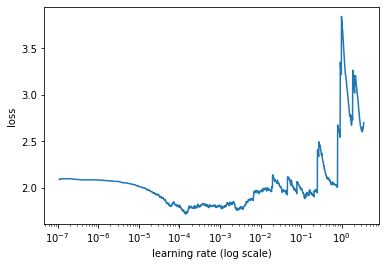

In [40]:
learner.lr_find()             # briefly simulate training to find good learning rate
learner.lr_plot()             # visually identify best learning rate

In [49]:

learner.autofit(0.0001, 1000,checkpoint_folder='./save/')

C:\Users\Rzhang\Anaconda3\envs\nlp\lib\site-packages\ktrain\core.py:792: UserWarning: cyclical momentum has been disabled because optimizer is not "Adam-like" with beta_1 param
  warnings.warn('cyclical momentum has been disabled because '+\




begin training using triangular learning rate policy with max lr of 0.0001...
Train for 319 steps, validate for 36 steps
Epoch 1/1000
  1/319 [..............................] - ETA: 45:17

TypeError: Cannot convert value 0 to a TensorFlow DType.

In [28]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  134734080 
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  6152      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 135,330,824
Trainable params: 135,330,824
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.layers[0].trainable = True

In [20]:
model.save('/save/')

INFO:tensorflow:Assets written to: /save/assets


In [43]:
model.save_pretrained('./save/')

In [51]:
model.load_weights('./save/')

AttributeError: 'TFDistilBertForSequenceClassification' object has no attribute 'load'

# Long Bert